# Fake News Classifier
Build a system to identify unreliable news articles

## Business Problem:

#### Problem Statemtent:
Build a system to identify unreliable news articles

#### Dataset Description
1. [Dataset is taken from Kaggle](https://www.kaggle.com/c/fake-news)

2. `train.csv:` A full training dataset with the following attributes:
    - **id:** unique id for a news article
    - **title:** the title of a news article
    - **author:** author of the news article
    - **text:** the text of the article; could be incomplete
    - **label:** a label that marks the article as potentially unreliable
        - **1:** Fake news
        - **0:** Real news

3. `test.csv:` A testing training dataset with all the same attributes at train.csv without the label.

## Importing required Libraries

In [1]:
import os
import re
from bs4 import BeautifulSoup
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1.Load dataset

In [3]:
# Load the train dataset
train_df = pd.read_csv('../input/fake-news/train.csv')

# Load the test dataset
test_df = pd.read_csv('../input/fake-news/test.csv')

In [4]:
train_df.head(10)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


**`label` column is target.**

- 1 = Fake News
- 0 = Real News

In [5]:
train_df.shape

(20800, 5)

## 2.Data Preparation

### 2.1 Remove empty `text news`

In [6]:
# Assign nan in place of blanks in the text column

train_df['text'] = train_df['text'].str.strip()
train_df['text'] = train_df['text'].replace(r'^\s*$', np.nan, regex=True)

In [7]:
# Remove all rows where complaints column is nan
train_df.dropna(subset=['text'], inplace=True)

### 2.2 Checking duplicates

`News text` might contain duplicate entries. So, we need to remove the duplicate entries so that we get unbiased data for Analysis.

In [8]:
train_df.duplicated(subset=["text"]).value_counts()

False    20378
True       306
dtype: int64

As we can see that we have few duplicate entries for `text` column

In [9]:
dup = train_df[train_df.duplicated(subset=["text"])]
dup.head()

,id,title,author,text,label
480,480,Watch: Muslim ‘Palestinians’ Declare “We follo...,admin,jewsnews © 2015 | JEWSNEWS | It's not news...u...,1
734,734,WikiLeaks Documents Reveal United Nations Inte...,Madeline,Click Here To Learn More About Alexandra's Per...,1
948,948,Comment on 4 of the Best Kinds of Milk That Ar...,4 of the Best Kinds of Milk That Aren’t Dairy ...,"Now, numerous studies have concluded that milk...",1
1292,1292,NaN,Anonymous,"Same people all the time , i dont know how you...",1
1486,1486,SAY WHAT? Chicago Tribune calls on Democrats t...,BareNakedIslam,Notify me of follow-up comments by email. Noti...,1


In [10]:
# print one duplicate entry
train_df[train_df['text'] == dup.loc[480]['text']]

,id,title,author,text,label
372,372,IRANIAN MISSILE ACCIDENTALLY DESTROYS IRANIAN ...,admin,jewsnews © 2015 | JEWSNEWS | It's not news...u...,1
480,480,Watch: Muslim ‘Palestinians’ Declare “We follo...,admin,jewsnews © 2015 | JEWSNEWS | It's not news...u...,1
7275,7275,ATTENTION WESTERN WORLD: If You Care About You...,admin,jewsnews © 2015 | JEWSNEWS | It's not news...u...,1
20174,20174,EPIC: Brave German woman beats the absolute he...,admin,jewsnews © 2015 | JEWSNEWS | It's not news...u...,1


**Drop duplicated data**

In [11]:
# drop duplicated data
train_df = train_df.drop_duplicates(subset={"text"}, keep='first', inplace=False)
train_df.shape

(20378, 5)

### 2.3 Replacing the null values

In [12]:
# Checking for missing values in the dataset
train_df.isnull().sum()

id           0
title      518
author    1852
text         0
label        0
dtype: int64

In [13]:
# dropping the nan values
train_df = train_df.fillna('')

## 3. Preprocessing Text

We will perform the below preprocessing tasks:
- Convert everything to lowercase
- Remove HTML tags
- Remove URL from sentence
- Contraction mapping
- Eliminate punctuations and special characters
- Remove stopwords
- Remove short words

In [14]:
stopword_list = stopwords.words('english')
print(stopword_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [15]:
!pip install contractions

     |████████████████████████████████| 321 kB 893 kB/s eta 0:00:01
     |████████████████████████████████| 284 kB 15.9 MB/s eta 0:00:01
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=102808 sha256=1c8d861db0a0b12c3988fdfb38aac014b5c08c8c17582d45ba4728d3d39a499f
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [16]:
import contractions
def decontracted(sentance):
    expanded_words = []    
    for word in sentance.split():
      # using contractions.fix to expand the shotened words
      expanded_words.append(contractions.fix(word))   

    expanded_text = ' '.join(expanded_words)
    return expanded_text

In [17]:
def sentance_clean(sentance):
    # change sentence to lower case
    sentance = sentance.lower()
    # removing URL from sentence
    sentance = re.sub(r"http\S+", "", sentance)
    # removing HTML tags
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    # removing contraction of words from sentence   # call decontracted funtion for it
    sentance = decontracted(sentance)
    # removing digits
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    # removing special character
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    
    return sentance

In [18]:
# Use Stemming 
ps = PorterStemmer()

# Performing the preprocessing steps on all messages
def preprocess(document):
    preprocessed_reviews = []
    # tqdm is for printing the status bar
    for sentance in tqdm(document):
        # call sentance_clean function to clean text
        sentance = sentance_clean(sentance)
        # tokenize into words
        words = word_tokenize(sentance)
        # remove stop words
        tokens = [ps.stem(word) for word in words if word not in stopword_list]

        # join words to make sentence
        sentance = " ".join(tokens).strip()

        preprocessed_reviews.append(sentance)
        
    return preprocessed_reviews

In [22]:
%%time
corpus = preprocess(train_df['text'])

100%|██████████| 20378/20378 [09:31<00:00, 35.69it/s]

CPU times: user 9min 30s, sys: 2.74 s, total: 9min 33s
Wall time: 9min 31s


In [23]:
print("Before preprocess\n", train_df['text'][1])
print("***"*40)
print("After preprocess\n", corpus[1])

Before preprocess
 Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress.  Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduating class. The president of the college informed those gathered in 1969 that the students needed “no debate so far as I could ascertain as to who their spokesman was to be” (kind of the like the Democratic primaries in 2016 minus the   terms unknown then even at a Seven Sisters school). “I am very glad that Miss Adams made it clear that what I am speaking for today is all of us —  the 400 of us,” Miss Rodham told her classmates. After appointing herself Edger Bergen to the Charlie

In [24]:
train_df['text'] = corpus

## 4. Vectorization

In [25]:
# Seperating the data and the label 
x = train_df['text'].values
y = train_df['label'].values

### 4.1 TF-IDF Vectorizer

In [26]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,3))
X = tfidf_vectorizer.fit_transform(x)

In [36]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [37]:
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (16302, 5000)
Test size: (4076, 5000)


## 5.Model

In [176]:
def plot_confusion_matrix(y_actual, y_pred):
    '''
    This method plots confusion matrix.
    '''
    classes = ['Fake News', 'Real News']
    tick_marks = np.arange(len(classes))

    accuracy = accuracy_score(y_actual, y_pred)
    print("Accuracy score:", "{:2.3}".format(accuracy))

    conf_matrix = confusion_matrix(y_actual, y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(conf_matrix, cmap=plt.cm.Reds, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')
    
    plt.tight_layout()
    plt.xticks(tick_marks , classes, rotation=0)
    plt.yticks(tick_marks , classes)
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.title('Confusion Matrix', fontsize=12)
    plt.show()

In [177]:
metrics_dict = {}

## 5.1 Logistic Regression

In [178]:
#  logistic regression object
model = LogisticRegression(C=5)
model.fit(X_train, y_train)

LogisticRegression(C=5)

In [179]:
# predict on train data
X_train_predict = model.predict(X_train)
# train_accuracy
train_accuracy = accuracy_score(y_train, X_train_predict)

# predict on test data
X_test_predict = model.predict(X_test)
# test_accuracy
test_accuracy = accuracy_score(y_test, X_test_predict)

In [180]:
accuracy = accuracy_score(y_test, X_test_predict)
LR_TF_TFIDF = {'Vectorizer': 'TF-IDF', 'Algorithm': 'Logistic_Regression_1', 
               'Train Accuracy':train_accuracy, 'Test Accuracy':test_accuracy}
metrics_dict['Logistic_Regression_TF_IDF'] = LR_TF_TFIDF

Accuracy score: 0.953


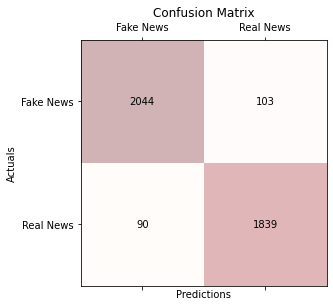

In [181]:
# plot confusion matrix on test
plot_confusion_matrix(y_test, X_test_predict)

## 5.2 Naive Bayes

In [182]:
#  logistic regression object
nb_model = MultinomialNB(alpha=0.8)
nb_model.fit(X_train, y_train)

MultinomialNB(alpha=0.8)

In [183]:
# predict on train data
X_train_predict = nb_model.predict(X_train)
# train_accuracy
train_accuracy = accuracy_score(y_train, X_train_predict)

# predict on test data
X_test_predict = nb_model.predict(X_test)
# test_accuracy
test_accuracy = accuracy_score(y_test, X_test_predict)

In [184]:
NB_TF_TFIDF = {'Vectorizer': 'TF-IDF', 'Algorithm': 'Naive_Bayes_1', 
               'Train Accuracy':train_accuracy, 'Test Accuracy':test_accuracy}
metrics_dict['Naive_Bayes_TF_IDF'] = NB_TF_TFIDF

Accuracy score: 0.893


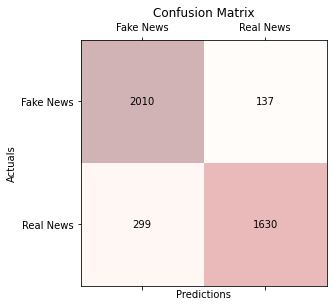

In [185]:
# plot confusion matrix on test
plot_confusion_matrix(y_test, X_test_predict)

## 6. Evolution Metrics

In [186]:
def metrics_table(metrics_dict):
    '''
    Metrics evolution table.
    '''   
    df = []
    for key, value in metrics_dict.items():
        df.append(metrics_dict[key])
    df = pd.DataFrame(df)
    df.set_index('Algorithm', inplace=True)
    return df

In [187]:
metrics_table(metrics_dict)

,Vectorizer,Train Accuracy,Test Accuracy
Algorithm,,,
Logistic_Regression_1,TF-IDF,0.985891,0.952650
Naive_Bayes_1,TF-IDF,0.903018,0.893032


### Conclusion:
- Logistic regression with TF-IDF model are giving good reault.